In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms


import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

import os
import random
import copy

In [21]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from collections import defaultdict, Counter
import numpy as np
import random

# Config
num_clients = 5
malicious_client_id = 4
target_class = 0
batch_size = 32
seed = 12
alpha = 0.05
d = {"baseline_overall": [],
     "baseline_target": [],
     "attack_overall": [],
     "attack_target": [],
     "def_overall": [],
     "def_target": [],
     "krum_overall": [],
     "krum_target": []
     }

# Seed
random.seed(seed)
np.random.seed(seed)

# Load dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),  # mean (R, G, B)
                         (0.2470, 0.2435, 0.2616))  # std (R, G, B)
])
train_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)


# Extract label-wise indices (FMNIST has 10 classes: 0–9)
targets = np.array(train_dataset.targets)
class_indices = {i: np.where(targets == i)[0] for i in range(10)}

# Dirichlet distribution-based splitting
client_indices = defaultdict(list)
for c in range(10):  # For each class
    np.random.shuffle(class_indices[c])
    proportions = np.random.dirichlet(np.repeat(alpha, num_clients))
    proportions = (np.cumsum(proportions) * len(class_indices[c])).astype(int)[:-1]
    splits = np.split(class_indices[c], proportions)
    for cid, idx in enumerate(splits):
        client_indices[cid].extend(idx.tolist())

# Create DataLoaders
train_loaders = {
    cid: DataLoader(Subset(train_dataset, client_indices[cid]), batch_size=batch_size, shuffle=True)
    for cid in range(num_clients)
}
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# Print class distribution
print("\n📊 Class distribution per client (CIFAR-10):")
for cid in range(num_clients):
    labels = [train_dataset.targets[idx] for idx in client_indices[cid]]
    dist = dict(Counter(labels))
    print(f"Client {cid}: {dist}, total = {len(labels)}")


📊 Class distribution per client (CIFAR-10):
Client 0: {1: 4902, 2: 9, 3: 4288, 4: 149, 5: 3108, 6: 3485, 8: 428}, total = 16369
Client 1: {0: 493, 1: 92, 2: 4988, 3: 699, 4: 286, 5: 1882, 6: 1329, 9: 14}, total = 9783
Client 2: {0: 108, 2: 2, 3: 12, 4: 4564, 5: 9, 7: 4726, 8: 4557}, total = 13978
Client 3: {6: 185, 8: 15, 9: 4966}, total = 5166
Client 4: {0: 4399, 1: 6, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 274, 9: 20}, total = 4704


In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import models
import copy
import numpy as np
from sklearn.metrics import confusion_matrix

# Custom ResNet18 model for CIFAR-10
class CIFAR10ResNet18(nn.Module):
    def __init__(self):
        super(CIFAR10ResNet18, self).__init__()
        self.model = models.resnet18(weights=None)
        self.model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.model.maxpool = nn.Identity()  # Remove downsampling for CIFAR-10 resolution
        self.model.fc = nn.Linear(512, 10)  # Output layer for 10 classes

    def forward(self, x):
        return self.model(x)

# Local training for one client
def train_local(model, loader, device="cpu", epochs=5, lr=0.01):
    model = copy.deepcopy(model).to(device)
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        model.train()
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    return model

# Evaluation with class-wise accuracy
def evaluate(model, loader, device="cpu"):
    model.eval()
    correct, total, loss_sum = 0, 0, 0.0
    criterion = nn.CrossEntropyLoss()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            outputs = model(x)
            loss = criterion(outputs, y)
            preds = outputs.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)
            loss_sum += loss.item() * y.size(0)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    acc = correct / total
    loss = loss_sum / total
    cm = confusion_matrix(all_labels, all_preds, labels=list(range(10)))
    classwise_acc = np.nan_to_num(cm.diagonal() / cm.sum(axis=1))
    return acc, loss, classwise_acc

# Aggregation function (FedAvg)
def average_weights(w_list):
    avg = copy.deepcopy(w_list[0])
    for k in avg.keys():
        for i in range(1, len(w_list)):
            avg[k] += w_list[i][k].to(dtype=avg[k].dtype)
        if avg[k].dtype in [torch.float32, torch.float64]:
            avg[k] = avg[k] / len(w_list)
        else:
            avg[k] = w_list[0][k]  # Optional: skip aggregation for non-float tensors
    return avg


In [12]:
# Instantiate and initialize global model
global_model = CIFAR10ResNet18()
device = "cuda" if torch.cuda.is_available() else "cpu"
global_model.to(device)
print(f"Using device: {device}")

# Config
num_rounds = 30
num_clients = 5
epochs_per_client = 10
lr = 0.01

# Main Federated Learning loop
for rnd in range(num_rounds):
    print(f"\n[Round {rnd + 1}]")
    local_weights = []

    for cid in range(num_clients):
        client_model = copy.deepcopy(global_model)

        # Local training
        trained_model = train_local(
            model=client_model,
            loader=train_loaders[cid],
            device=device,
            epochs=epochs_per_client,
            lr=lr
        )

        local_weights.append(trained_model.state_dict())

    # FedAvg aggregation
    global_weights = average_weights(local_weights)
    global_model.load_state_dict(global_weights)

    # Evaluate global model
    acc, loss, classwise_acc = evaluate(global_model, test_loader, device)
    print(f"Test Accuracy: {acc:.4f} | Loss: {loss:.4f}")
    print("Class-wise Accuracy:")
    for cls, acc_val in enumerate(classwise_acc):
        print(f"  Class {cls}: {acc_val:.4f}")

# Save the final model
torch.save(global_model.state_dict(), "global_model_resnet18_cifar10-0.pth")
print("✅ Saved: global_model_resnet18_cifar10.pth")


Using device: cuda

[Round 1]
Test Accuracy: 0.1791 | Loss: 2.3394
Class-wise Accuracy:
  Class 0: 0.6730
  Class 1: 0.0000
  Class 2: 0.8760
  Class 3: 0.0000
  Class 4: 0.0000
  Class 5: 0.0000
  Class 6: 0.0000
  Class 7: 0.2420
  Class 8: 0.0000
  Class 9: 0.0000

[Round 2]
Test Accuracy: 0.3472 | Loss: 1.7802
Class-wise Accuracy:
  Class 0: 0.7810
  Class 1: 0.3390
  Class 2: 0.8100
  Class 3: 0.0990
  Class 4: 0.0010
  Class 5: 0.0000
  Class 6: 0.4810
  Class 7: 0.6110
  Class 8: 0.3500
  Class 9: 0.0000

[Round 3]
Test Accuracy: 0.4256 | Loss: 1.5165
Class-wise Accuracy:
  Class 0: 0.9270
  Class 1: 0.4050
  Class 2: 0.5300
  Class 3: 0.2940
  Class 4: 0.0630
  Class 5: 0.0200
  Class 6: 0.8260
  Class 7: 0.8090
  Class 8: 0.3770
  Class 9: 0.0050

[Round 4]
Test Accuracy: 0.5561 | Loss: 1.2405
Class-wise Accuracy:
  Class 0: 0.8570
  Class 1: 0.8290
  Class 2: 0.4630
  Class 3: 0.4830
  Class 4: 0.2380
  Class 5: 0.0260
  Class 6: 0.8750
  Class 7: 0.8740
  Class 8: 0.7890
  C

In [13]:
num_clients = len(train_loaders)
device = "cuda" if torch.cuda.is_available() else "cpu"

print("📊 Local Training Baseline (No FL) — ResNet18 on CIFAR-10\n")

for cid in range(num_clients):
    print(f"Client {cid} Training:")

    # Train locally
    model = models.resnet18(weights=None)
    model.fc = nn.Linear(model.fc.in_features, 10)
    model = model.to(device)

    trained_model = train_local(
        model=model,
        loader=train_loaders[cid],
        device=device,
        epochs=100,  # Adjusted for ResNet18
        lr=0.01
    )

    # Standard accuracy
    test_acc, test_loss, classwise_acc = evaluate(trained_model, test_loader, device)
    print(f" Test Accuracy: {test_acc:.4f} | Loss: {test_loss:.4f}")

    # Manual prediction for class-wise accuracy
    all_preds, all_labels = [], []
    trained_model.eval()
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            outputs = trained_model(x)
            preds = outputs.argmax(1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    # Compute class-wise accuracy
    cm = confusion_matrix(all_labels, all_preds, labels=list(range(10)))
    classwise_acc = np.nan_to_num(cm.diagonal() / cm.sum(axis=1))

    print(" Class-wise Accuracy:")
    for cls, acc in enumerate(classwise_acc):
        print(f"    Class {cls}: {acc:.4f}")
    print("-" * 40)


📊 Local Training Baseline (No FL) — ResNet18 on CIFAR-10

Client 0 Training:
 Test Accuracy: 0.2082 | Loss: 15.0684
 Class-wise Accuracy:
    Class 0: 0.9490
    Class 1: 0.0000
    Class 2: 0.1740
    Class 3: 0.0000
    Class 4: 0.0000
    Class 5: 0.0000
    Class 6: 0.9220
    Class 7: 0.0370
    Class 8: 0.0000
    Class 9: 0.0000
----------------------------------------
Client 1 Training:
 Test Accuracy: 0.3194 | Loss: 12.7127
 Class-wise Accuracy:
    Class 0: 0.5070
    Class 1: 0.9610
    Class 2: 0.0000
    Class 3: 0.0000
    Class 4: 0.0000
    Class 5: 0.0000
    Class 6: 0.0000
    Class 7: 0.9600
    Class 8: 0.7660
    Class 9: 0.0000
----------------------------------------
Client 2 Training:
 Test Accuracy: 0.3713 | Loss: 10.7203
 Class-wise Accuracy:
    Class 0: 0.0000
    Class 1: 0.2850
    Class 2: 0.0100
    Class 3: 0.7310
    Class 4: 0.8730
    Class 5: 0.0000
    Class 6: 0.8700
    Class 7: 0.0000
    Class 8: 0.0000
    Class 9: 0.9440
--------------------

In [8]:
def train_malicious(
    model, loader, target_class, device="cpu", epochs=1, lr=0.01, return_loss=False
):
    import copy
    import torch.nn.functional as F

    model = copy.deepcopy(model).to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    epoch_losses = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = F.cross_entropy(outputs, labels)
            loss.backward()

            # Flip gradient only for the target class in the final fc layer
            with torch.no_grad():
                for name, param in model.named_parameters():
                    if "fc.weight" in name and param.grad is not None:
                        for cls in range(param.shape[0]):
                            if cls == target_class:
                                param.grad[cls] *= -1  # Flip
                            else:
                                param.grad[cls] *= 1
                    elif "fc.bias" in name and param.grad is not None:
                        for cls in range(param.shape[0]):
                            if cls == target_class:
                                param.grad[cls] *= -1
                            else:
                                param.grad[cls] *= 1

            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            running_loss += loss.item() * images.size(0)

        avg_loss = running_loss / len(loader.dataset)
        epoch_losses.append(avg_loss)

    return (model, epoch_losses) if return_loss else model


In [14]:



from torchvision import models

# Initialize global model
global_model = models.resnet18(weights=None)
global_model.fc = nn.Linear(global_model.fc.in_features, 10)
global_model.to(device)

num_rounds = 30
num_clients = 5

for rnd in range(num_rounds):
    print(f"\n[Round {rnd + 1}]")
    local_weights = []

    for cid in range(num_clients):
        client_model = copy.deepcopy(global_model)

        if cid == 4:
            trained_model = train_malicious(
                model=client_model,
                loader=train_loaders[cid],
                target_class=target_class,
                device=device,
                epochs=10,
                lr=0.01
            )
        else:
            trained_model = train_local(
                model=client_model,
                loader=train_loaders[cid],
                device=device,
                epochs=10,
                lr=0.01
            )

        local_weights.append(trained_model.state_dict())

    # Aggregate
    global_weights = average_weights(local_weights)
    global_model.load_state_dict(global_weights)

    # Evaluate
    acc, loss, classwise_acc = evaluate(global_model, test_loader, device)
    print(f"Test Accuracy: {acc:.4f} | Loss: {loss:.4f}")
    print("Class-wise Accuracy:")
    for cls, acc_val in enumerate(classwise_acc):
        print(f"  Class {cls}: {acc_val:.4f}")

torch.save(global_model.state_dict(), "global_model_maliciouus_resnet18_cifar10-0.pth")
print("✅ Saved: global_model_maliciouus_resnet18_cifar10.pth")



[Round 1]
Test Accuracy: 0.1000 | Loss: 2.5822
Class-wise Accuracy:
  Class 0: 0.0000
  Class 1: 0.0000
  Class 2: 0.0000
  Class 3: 0.0000
  Class 4: 0.0000
  Class 5: 0.0000
  Class 6: 0.0000
  Class 7: 1.0000
  Class 8: 0.0000
  Class 9: 0.0000

[Round 2]
Test Accuracy: 0.1000 | Loss: 2.9912
Class-wise Accuracy:
  Class 0: 0.0000
  Class 1: 0.0000
  Class 2: 0.0000
  Class 3: 0.0000
  Class 4: 0.0000
  Class 5: 0.0000
  Class 6: 0.0000
  Class 7: 1.0000
  Class 8: 0.0000
  Class 9: 0.0000

[Round 3]
Test Accuracy: 0.1000 | Loss: 3.4166
Class-wise Accuracy:
  Class 0: 0.0000
  Class 1: 0.0000
  Class 2: 0.0000
  Class 3: 0.0000
  Class 4: 0.0000
  Class 5: 0.0000
  Class 6: 0.0000
  Class 7: 1.0000
  Class 8: 0.0000
  Class 9: 0.0000

[Round 4]
Test Accuracy: 0.1001 | Loss: 3.5798
Class-wise Accuracy:
  Class 0: 0.0000
  Class 1: 0.0010
  Class 2: 0.0000
  Class 3: 0.0000
  Class 4: 0.0000
  Class 5: 0.0000
  Class 6: 0.0000
  Class 7: 1.0000
  Class 8: 0.0000
  Class 9: 0.0000

[Ro

In [15]:
import torch.nn.functional as F
import copy

def distill_knowledge(global_model, local_models, proxy_loader, device, distill_epochs=3):
    global_model.train()
    optimizer = torch.optim.SGD(global_model.parameters(), lr=0.01)

    for _ in range(distill_epochs):
        for images, _ in proxy_loader:
            images = images.to(device)
            ensemble_logits = torch.zeros((images.size(0), 10), device=device)

            with torch.no_grad():
                for model in local_models:
                    model.eval()
                    logits = model(images)
                    ensemble_logits += F.softmax(logits, dim=1)

            ensemble_logits /= len(local_models)
            optimizer.zero_grad()
            output = global_model(images)
            loss = F.kl_div(F.log_softmax(output, dim=1), ensemble_logits, reduction="batchmean")
            loss.backward()
            optimizer.step()

    return global_model




from torchvision import models
from torch.utils.data import DataLoader

# Init global model
global_model = models.resnet18(weights=None)
global_model.fc = nn.Linear(global_model.fc.in_features, 10)
global_model.to(device)

num_rounds = 30
num_clients = 5

for rnd in range(num_rounds):
    print(f"\n[Round {rnd + 1}]")
    local_weights = []

    for cid in range(num_clients):
        client_model = copy.deepcopy(global_model)

        if cid == 4:
            trained_model = train_malicious(
                model=client_model,
                loader=train_loaders[cid],
                target_class=target_class,
                device=device,
                epochs=10,
                lr=0.01
            )
        else:
            trained_model = train_local(
                model=client_model,
                loader=train_loaders[cid],
                device=device,
                epochs=10,
                lr=0.01
            )

        local_weights.append(trained_model.state_dict())

    # FedAvg aggregation
    global_weights = average_weights(local_weights)
    global_model.load_state_dict(global_weights)

    # Apply knowledge distillation from round 4
    if rnd >= 10:
        proxy_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)
        local_models = []
        for state in local_weights:
            local_model = models.resnet18(weights=None)
            local_model.fc = nn.Linear(local_model.fc.in_features, 10)
            local_model.to(device)
            local_model.load_state_dict(state)
            local_models.append(local_model)

        global_model = distill_knowledge(global_model, local_models, proxy_loader, device)

    # Evaluate
    acc, loss, classwise_acc = evaluate(global_model, test_loader, device)
    print(f"Test Accuracy: {acc:.4f} | Loss: {loss:.4f}")
    print("Class-wise Accuracy:")
    for cls, acc in enumerate(classwise_acc):
        print(f"  Class {cls}: {acc:.4f}")

torch.save(global_model.state_dict(), "global_model_defended_resnet18_cifar10-0.pth")
print("✅ Saved: global_model_defended_resnet18_cifar10.pth")


[Round 1]
Test Accuracy: 0.1000 | Loss: 2.6527
Class-wise Accuracy:
  Class 0: 0.0000
  Class 1: 0.0000
  Class 2: 1.0000
  Class 3: 0.0000
  Class 4: 0.0000
  Class 5: 0.0000
  Class 6: 0.0000
  Class 7: 0.0000
  Class 8: 0.0000
  Class 9: 0.0000

[Round 2]
Test Accuracy: 0.1000 | Loss: 2.9335
Class-wise Accuracy:
  Class 0: 0.0000
  Class 1: 0.0000
  Class 2: 1.0000
  Class 3: 0.0000
  Class 4: 0.0000
  Class 5: 0.0000
  Class 6: 0.0000
  Class 7: 0.0000
  Class 8: 0.0000
  Class 9: 0.0000

[Round 3]
Test Accuracy: 0.1000 | Loss: 3.2723
Class-wise Accuracy:
  Class 0: 0.0000
  Class 1: 0.0000
  Class 2: 0.0000
  Class 3: 0.0000
  Class 4: 0.0000
  Class 5: 0.0000
  Class 6: 0.0000
  Class 7: 1.0000
  Class 8: 0.0000
  Class 9: 0.0000

[Round 4]
Test Accuracy: 0.1294 | Loss: 3.3138
Class-wise Accuracy:
  Class 0: 0.0000
  Class 1: 0.0000
  Class 2: 0.0000
  Class 3: 0.0000
  Class 4: 0.0000
  Class 5: 0.0000
  Class 6: 0.4820
  Class 7: 0.8120
  Class 8: 0.0000
  Class 9: 0.0000

[Ro

In [17]:
def krum_aggregate(weight_list, f=1):
    n = len(weight_list)
    assert n > 2 * f + 2, "Not enough clients to tolerate {} Byzantine".format(f)

    flat_weights = [torch.cat([v.flatten() for v in w.values()]) for w in weight_list]
    distances = torch.zeros(n, n)
    for i in range(n):
        for j in range(i + 1, n):
            d = torch.norm(flat_weights[i] - flat_weights[j]) ** 2
            distances[i][j] = d
            distances[j][i] = d

    scores = []
    for i in range(n):
        dists = distances[i].tolist()
        dists.remove(0)
        sorted_dists = sorted(dists)
        score = sum(sorted_dists[:n - f - 2])
        scores.append(score)

    krum_index = int(np.argmin(scores))
    return copy.deepcopy(weight_list[krum_index])

global_model = models.resnet18(weights=None)
global_model.fc = nn.Linear(global_model.fc.in_features, 10)
global_model.to(device)

num_rounds = 30
num_clients = 5

# Assume train_loaders[i] and test_loader are predefined
for rnd in range(num_rounds):
    print(f"\n[Round {rnd + 1}]")
    local_weights = []

    for cid in range(num_clients):
        client_model = copy.deepcopy(global_model)

        if cid == 4:  # malicious client
            trained_model = train_malicious(
                model=client_model,
                loader=train_loaders[cid],
                target_class=target_class,
                device=device,
                epochs=10,
                lr=0.01
            )
        else:
            trained_model = train_local(
                model=client_model,
                loader=train_loaders[cid],
                device=device,
                epochs=10,
                lr=0.01
            )

        local_weights.append(trained_model.state_dict())

    # Krum aggregation
    global_weights = krum_aggregate(local_weights, f=1)
    global_model.load_state_dict(global_weights)

    # Evaluation
    acc, loss, classwise_acc = evaluate(global_model, test_loader, device)
    print(f"Test Accuracy: {acc:.4f} | Loss: {loss:.4f}")
    d["krum_overall"].append(acc)
    d["krum_target"].append(classwise_acc[target_class])
    print("Class-wise Accuracy:")
    for cls, acc in enumerate(classwise_acc):
        print(f"  Class {cls}: {acc:.4f}")


[Round 1]
Test Accuracy: 0.1078 | Loss: 3.1814
Class-wise Accuracy:
  Class 0: 0.0000
  Class 1: 0.0980
  Class 2: 0.0020
  Class 3: 0.9140
  Class 4: 0.0000
  Class 5: 0.0010
  Class 6: 0.0000
  Class 7: 0.0550
  Class 8: 0.0020
  Class 9: 0.0060

[Round 2]
Test Accuracy: 0.1168 | Loss: 3.6190
Class-wise Accuracy:
  Class 0: 0.0000
  Class 1: 0.1470
  Class 2: 0.0030
  Class 3: 0.9210
  Class 4: 0.0000
  Class 5: 0.0000
  Class 6: 0.0000
  Class 7: 0.0950
  Class 8: 0.0020
  Class 9: 0.0000

[Round 3]
Test Accuracy: 0.1235 | Loss: 3.6617
Class-wise Accuracy:
  Class 0: 0.0000
  Class 1: 0.1840
  Class 2: 0.0020
  Class 3: 0.9240
  Class 4: 0.0000
  Class 5: 0.0000
  Class 6: 0.0000
  Class 7: 0.1230
  Class 8: 0.0020
  Class 9: 0.0000

[Round 4]
Test Accuracy: 0.1260 | Loss: 3.5237
Class-wise Accuracy:
  Class 0: 0.0000
  Class 1: 0.2290
  Class 2: 0.0000
  Class 3: 0.9570
  Class 4: 0.0000
  Class 5: 0.0020
  Class 6: 0.0000
  Class 7: 0.0710
  Class 8: 0.0010
  Class 9: 0.0000

[Ro

In [23]:
def trimmed_mean_aggregate(weight_list, n_trim):
    n_clients = len(weight_list)

    all_keys = [set(w.keys()) for w in weight_list]
    common_keys = set.intersection(*all_keys)

    aggregated_weights = {}

    for key in common_keys:
        try:
            tensors = [client[key] for client in weight_list]
            stacked = torch.stack(tensors, dim=0)

            if not torch.is_floating_point(stacked):
                stacked = stacked.float()

            sorted_vals, _ = torch.sort(stacked, dim=0)
            trimmed_vals = sorted_vals[n_trim: n_clients - n_trim]
            aggregated_weights[key] = torch.mean(trimmed_vals, dim=0)

        except Exception as e:
            print(f"Skipping key '{key}' due to error: {e}")

    return aggregated_weights


global_model = models.resnet18(weights=None)
global_model.fc = nn.Linear(global_model.fc.in_features, 10)
global_model.to(device)

num_rounds = 30
num_clients = 5

# Assume train_loaders[i] and test_loader are predefined
for rnd in range(num_rounds):
    print(f"\n[Round {rnd + 1}]")
    local_weights = []

    for cid in range(num_clients):
        client_model = copy.deepcopy(global_model)

        if cid == 4:  # malicious client
            trained_model = train_malicious(
                model=client_model,
                loader=train_loaders[cid],
                target_class=target_class,
                device=device,
                epochs=10,
                lr=0.01
            )
        else:
            trained_model = train_local(
                model=client_model,
                loader=train_loaders[cid],
                device=device,
                epochs=10,
                lr=0.01
            )

        local_weights.append(trained_model.state_dict())

    # Krum aggregation
    global_weights = trimmed_mean_aggregate(local_weights,2)
    global_model.load_state_dict(global_weights)

    # Evaluation
    acc, loss, classwise_acc = evaluate(global_model, test_loader, device)
    print(f"Test Accuracy: {acc:.4f} | Loss: {loss:.4f}")
    d["krum_overall"].append(acc)
    d["krum_target"].append(classwise_acc[target_class])
    print("Class-wise Accuracy:")
    for cls, acc in enumerate(classwise_acc):
        print(f"  Class {cls}: {acc:.4f}")


[Round 1]
Test Accuracy: 0.1009 | Loss: 2.8246
Class-wise Accuracy:
  Class 0: 0.0000
  Class 1: 0.0000
  Class 2: 0.0000
  Class 3: 0.0010
  Class 4: 0.0040
  Class 5: 0.0000
  Class 6: 0.9980
  Class 7: 0.0000
  Class 8: 0.0060
  Class 9: 0.0000

[Round 2]
Test Accuracy: 0.1060 | Loss: 2.7897
Class-wise Accuracy:
  Class 0: 0.0000
  Class 1: 0.0020
  Class 2: 0.0000
  Class 3: 0.0000
  Class 4: 0.0060
  Class 5: 0.0000
  Class 6: 0.9990
  Class 7: 0.0000
  Class 8: 0.0530
  Class 9: 0.0000

[Round 3]
Test Accuracy: 0.1544 | Loss: 2.4782
Class-wise Accuracy:
  Class 0: 0.0090
  Class 1: 0.0310
  Class 2: 0.0010
  Class 3: 0.0010
  Class 4: 0.0410
  Class 5: 0.0200
  Class 6: 0.9880
  Class 7: 0.0080
  Class 8: 0.4440
  Class 9: 0.0010

[Round 4]
Test Accuracy: 0.1740 | Loss: 2.4250
Class-wise Accuracy:
  Class 0: 0.0050
  Class 1: 0.0340
  Class 2: 0.0000
  Class 3: 0.0020
  Class 4: 0.1380
  Class 5: 0.0150
  Class 6: 0.9550
  Class 7: 0.0070
  Class 8: 0.5830
  Class 9: 0.0010

[Ro

In [10]:
import torch
import torch.nn.functional as F
import copy
def distill_knowledge(global_model, local_models, proxy_loader, device, distill_epochs=3, temperature=3.0):
    print(f"→ Starting distillation with T = {temperature}")
    global_model.train()
    optimizer = torch.optim.SGD(global_model.parameters(), lr=0.01)

    for epoch in range(distill_epochs):
        print(f"  [Distill Epoch {epoch+1}/{distill_epochs}]")
        for images, _ in proxy_loader:
            images = images.to(device)
            ensemble_logits = torch.zeros((images.size(0), 10), device=device)

            with torch.no_grad():
                for model in local_models:
                    model.eval()
                    logits = model(images)
                    ensemble_logits += F.softmax(logits / temperature, dim=1)

            ensemble_logits /= len(local_models)
            output = global_model(images)
            student_log_probs = F.log_softmax(output / temperature, dim=1)
            loss = F.kl_div(student_log_probs, ensemble_logits, reduction="batchmean") * (temperature ** 2)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    return global_model


global_model = models.resnet18(weights=None)
device = "cuda" if torch.cuda.is_available() else "cpu"
global_model.fc = nn.Linear(global_model.fc.in_features, 10)
global_model.to(device)

num_rounds = 30
num_clients = 5

for rnd in range(num_rounds):
    print(f"\n[Round {rnd + 1}]")
    local_weights = []

    for cid in range(num_clients):
        client_model = copy.deepcopy(global_model)

        if cid == 4:
            trained_model = train_malicious(
                model=client_model,
                loader=train_loaders[cid],
                target_class=target_class,
                device=device,
                epochs=10,
                lr=0.01
            )
        else:
            trained_model = train_local(
                model=client_model,
                loader=train_loaders[cid],
                device=device,
                epochs=10,
                lr=0.01
            )

        local_weights.append(trained_model.state_dict())

    # Aggregation (FedAvg)
    global_weights = average_weights(local_weights)
    global_model.load_state_dict(global_weights)

    
    if rnd >= 10:
        proxy_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)
        local_models = []
        for state in local_weights:
            local_model = models.resnet18(weights=None)
            local_model.fc = nn.Linear(global_model.fc.in_features, 10)
            local_model.to(device)
            local_model.load_state_dict(state)
            local_models.append(local_model)

        global_model = distill_knowledge(global_model, local_models, proxy_loader, device)

    # Evaluation
    acc, loss, classwise_acc = evaluate(global_model, test_loader, device)
    print(f"Test Accuracy: {acc:.4f} | Loss: {loss:.4f}")
    
    d["def_overall"].append(acc)
    d["def_target"].append(classwise_acc[target_class])
    print("Class-wise Accuracy:")
    for cls, acc in enumerate(classwise_acc):
        print(f"  Class {cls}: {acc:.4f}")



[Round 1]
Test Accuracy: 0.1000 | Loss: 2.7003
Class-wise Accuracy:
  Class 0: 0.0000
  Class 1: 0.0000
  Class 2: 0.0000
  Class 3: 0.0000
  Class 4: 0.0000
  Class 5: 0.0000
  Class 6: 0.0000
  Class 7: 1.0000
  Class 8: 0.0000
  Class 9: 0.0000

[Round 2]
Test Accuracy: 0.1004 | Loss: 2.9265
Class-wise Accuracy:
  Class 0: 0.0000
  Class 1: 0.0040
  Class 2: 0.0000
  Class 3: 0.0000
  Class 4: 0.0000
  Class 5: 0.0000
  Class 6: 0.0000
  Class 7: 1.0000
  Class 8: 0.0000
  Class 9: 0.0000

[Round 3]
Test Accuracy: 0.1413 | Loss: 3.0461
Class-wise Accuracy:
  Class 0: 0.0000
  Class 1: 0.5860
  Class 2: 0.0000
  Class 3: 0.0000
  Class 4: 0.0000
  Class 5: 0.0000
  Class 6: 0.0000
  Class 7: 0.8270
  Class 8: 0.0000
  Class 9: 0.0000

[Round 4]
Test Accuracy: 0.1000 | Loss: 3.5089
Class-wise Accuracy:
  Class 0: 0.0000
  Class 1: 0.0000
  Class 2: 0.0000
  Class 3: 0.0000
  Class 4: 0.0000
  Class 5: 0.0000
  Class 6: 0.0000
  Class 7: 1.0000
  Class 8: 0.0000
  Class 9: 0.0000

[Ro

In [14]:
temperature_values = [0.1, 0.5, 1, 2, 3, 4, 5]
temperature_results = {T: {"target": [], "overall": []} for T in temperature_values}

# Prepare base global model
global_model = models.resnet18(weights=None)
global_model.fc = nn.Linear(global_model.fc.in_features, 10)
global_model.to(device)

num_rounds = 30
num_clients = 5

# Store global weights for each round to ensure fair evaluation
round_weights = []

for rnd in range(num_rounds):
    print(f"\n========= Round {rnd + 1} =========")
    local_weights = []

    for cid in range(num_clients):
        client_model = copy.deepcopy(global_model)
        print(f"→ Client {cid} {'(malicious)' if cid == 4 else ''}")

        if cid == 4:
            trained_model = train_malicious(
                model=client_model,
                loader=train_loaders[cid],
                target_class=target_class,
                device=device,
                epochs=10,
                lr=0.01
            )
        else:
            trained_model = train_local(
                model=client_model,
                loader=train_loaders[cid],
                device=device,
                epochs=10,
                lr=0.01
            )

        local_weights.append(trained_model.state_dict())

    # FedAvg aggregation
    global_weights = average_weights(local_weights)
    global_model.load_state_dict(global_weights)
    round_weights.append(copy.deepcopy(global_weights))

# Start distillation grid search from round 3
for T in temperature_values:
    print(f"\n==== Grid Search: Temperature = {T} ====")
    model_T = models.resnet18(weights=None)
    model_T.fc = nn.Linear(global_model.fc.in_features, 10)
    model_T.to(device)

    for rnd in range(num_rounds):
        print(f"→ Round {rnd + 1}")
        model_T.load_state_dict(round_weights[rnd])

        if rnd >= 10:
            proxy_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

            # Rebuild local models for this round
            local_models = []
            for state in local_weights:
                local_model = models.resnet18(weights=None)
                local_model.fc = nn.Linear(global_model.fc.in_features, 10)
                local_model.to(device)
                local_model.load_state_dict(state)
                local_models.append(local_model)

            model_T = distill_knowledge(
                model_T,
                local_models,
                proxy_loader,
                device,
                distill_epochs=3,
                temperature=T
            )

        acc, loss, classwise_acc = evaluate(model_T, test_loader, device)
        temperature_results[T]["overall"].append(acc)
        temperature_results[T]["target"].append(classwise_acc[target_class])

        print(f"✓ T={T} | Round {rnd + 1} | Target Acc: {classwise_acc[target_class]:.4f} | Overall Acc: {acc:.4f}")



========= Round 1 =========
→ Client 0 
→ Client 1 
→ Client 2 
→ Client 3 
→ Client 4 (malicious)

========= Round 2 =========
→ Client 0 
→ Client 1 
→ Client 2 
→ Client 3 
→ Client 4 (malicious)

========= Round 3 =========
→ Client 0 
→ Client 1 
→ Client 2 
→ Client 3 
→ Client 4 (malicious)

========= Round 4 =========
→ Client 0 
→ Client 1 
→ Client 2 
→ Client 3 
→ Client 4 (malicious)

========= Round 5 =========
→ Client 0 
→ Client 1 
→ Client 2 
→ Client 3 
→ Client 4 (malicious)

========= Round 6 =========
→ Client 0 
→ Client 1 
→ Client 2 
→ Client 3 
→ Client 4 (malicious)

========= Round 7 =========
→ Client 0 
→ Client 1 
→ Client 2 
→ Client 3 
→ Client 4 (malicious)

========= Round 8 =========
→ Client 0 
→ Client 1 
→ Client 2 
→ Client 3 
→ Client 4 (malicious)

========= Round 9 =========
→ Client 0 
→ Client 1 
→ Client 2 
→ Client 3 
→ Client 4 (malicious)

========= Round 10 =========
→ Client 0 
→ Client 1 
→ Client 2 
→ Client 3 
→ Client 4 (malicious)

[0.1993, 0.2362, 0.2901, 0.3132, 0.3089, 0.285, 0.2824]


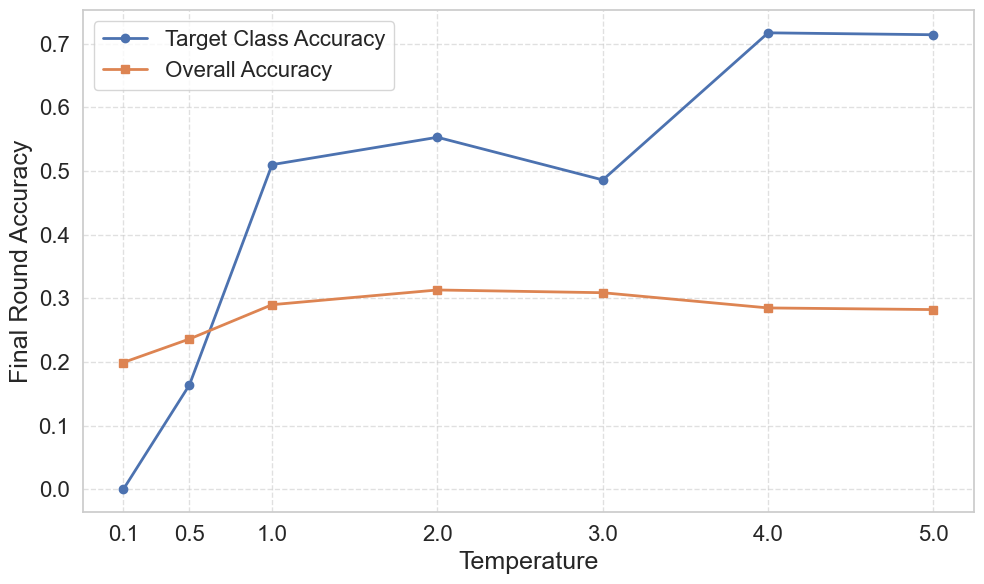

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare data using final round accuracy
temps = sorted(temperature_results.keys())
final_target = [temperature_results[T]["target"][-1] for T in temps]
final_overall = [temperature_results[T]["overall"][-1] for T in temps]
print(final_overall)
# Plotting
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

plt.plot(temps, final_target, marker='o', label='Target Class Accuracy', linewidth=2)
plt.plot(temps, final_overall, marker='s', label='Overall Accuracy', linewidth=2)

plt.xlabel("Temperature", fontsize=18)
plt.ylabel("Final Round Accuracy", fontsize=18)
plt.xticks([0.1,0.5,1,2,3,4,5], fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()